# Koala Hospital Data

**Joel Norman z5207799**

https://github.com/joelnorman99/Open-Data-Project

The data is provided from the Department of Environment and Heritage Protection koala hospital database (KoalaBase) between April 1996 - February 2017. 
The dataset contains approximately 40,000 reports with information about where the animal was reported, the gender, maturity level and health status at the time of initial assessment.

Source of data:
https://data.des.qld.gov.au/__data/assets/file/0024/83508/koalabase-1996-2017.csv 

In [16]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import shapely
import fiona
import geopandas as gp
from shapely.geometry import Polygon


Each report is made to the Moggill Koala Rehabilitation Centre (QLD) and the koalas are commonly admitted for treatment and/or rehabilitation for the following reasons:

- Chlamydial-related diseases such as conjunctivitis, cystitis, infertility and kidney failure
- Traumatic injuries caused by cars and dogs
- Orphaned joeys

Statistics are collected and entered into database which contains over 50,000 records. This information is used by the QLD department to produce maps and reports which guide koala management decisions.

In [17]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)


In [18]:
saved_style_state = matplotlib.rcParams.copy() #give us a style state to go back to
colors = plt.cm.Spectral(np.linspace(0, 1, 25))
h = 'helvetica'
plt.style.use('seaborn-whitegrid')

In [19]:
fp = 'maps/QLD_LOCALITY_POLYGON_shp.shp'
QLD = gp.GeoDataFrame.from_file(fp)
QLD.drop(["QLD_LOCA_1", "QLD_LOCA_3", "QLD_LOCA_4", "QLD_LOCA_6", "DT_RETIRE", "QLD_LOCA_7", "QLD_LOCA_5"], axis=1, inplace=True)

QLD.head()

,LC_PLY_PID,DT_CREATE,LOC_PID,QLD_LOCALI,QLD_LOCA_2,geometry
0,67839,2018-09-13,QLD1991,2016-08-10,MOUNT BERRYMAN,"POLYGON ((152.30132 -27.75523, 152.30122 -27.7..."
1,64808,2017-06-14,QLD2092,2017-08-10,MOUNTAIN CREEK,"POLYGON ((153.10559 -26.71514, 153.10323 -26.7..."
2,64939,2017-06-14,QLD1803,2017-08-10,MARCOOLA,"POLYGON ((153.09112 -26.61160, 153.09065 -26.6..."
3,67905,2018-09-13,QLD744,2018-05-09,COVERTY,"POLYGON ((151.44572 -26.33205, 151.44550 -26.3..."
4,63067,2016-06-29,QLD3331,2018-08-07,BOUNTIFUL ISLANDS,"POLYGON ((139.84126 -16.70989, 139.84113 -16.7..."


In [20]:
if os.path.isfile("koalabase.csv"):
    filepath = "koalabase.csv"
    print("loading from file")

koala_data = pd.read_csv(filepath)
print("done")

loading from file
done


/Users/joelnorman/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (17,18,19,20,21,22,23,24,25,26,27,29,31) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# Inital Exploration of Dataset

In [21]:
date = koala_data["Call Date "].str.split("/", expand = True)
koala_data["Year"]= date[2]
koala_data["Month"]= date[1]
koala_data.drop(["Animal Record No. ", "Release LNG", "Release LAT", "Wasted"], axis=1, inplace=True)
koala_data['Month'] = koala_data['Month'].replace({'01':'Jan', '02':'Feb','03':'Mar', '04':'Apr','05':'May', '06':'Jun','07':'Jul', '08':'Aug','09':'Sep', '10':'Oct','11':'Nov', '12':'Dec'})

In [22]:
koala_data.head()

,Call Date,Animal Name,LATITUDE,LONGITUDE,Adult Fate Other,Adult Size,Adult Gender,Adult Situation,Adult Situation Other,Young Present,...,Vehicle Hit,Road Speed Limit (Km),Fall,Injury Other,Status Other,Release Date,Release Suburb,Release Post Code,Year,Month
0,4/07/1996,SIGHTING,-27.182496,153.016159,NaN,Adult (More than 4kg),Unknown,In tree,NaN,False,...,False,NaN,False,NaN,NaN,NaN,NaN,NaN,1996,Jul
1,5/07/1996,SIGHTING,-27.638595,153.156763,NaN,Unknown (not recorded),Unknown,In tree,NaN,False,...,False,NaN,False,NaN,NaN,NaN,NaN,NaN,1996,Jul
2,1/01/1997,SIGHTING,NaN,NaN,NaN,Adult (More than 4kg),Unknown,In tree,NaN,False,...,False,NaN,False,NaN,NaN,NaN,NaN,NaN,1997,Jan
3,1/01/1997,PHILLY,-27.544270,153.224509,NaN,Sub-Adult (2-4kg),Male,In tree,NaN,False,...,False,NaN,False,NaN,NaN,9/01/1997,Alexandra Hills,4161.0,1997,Jan
4,1/01/1997,CARRIE,-27.516611,153.223217,NaN,Sub-Adult (2-4kg),Female,In tree,NaN,False,...,False,NaN,False,NaN,NaN,13/01/1997,Alexandra Hills,4161.0,1997,Jan


In [23]:
koala_data.columns

Index(['Call Date ', 'Animal Name', 'LATITUDE', 'LONGITUDE',
       'Adult Fate Other', 'Adult Size', 'Adult Gender', 'Adult Situation',
       'Adult Situation Other', 'Young Present', 'Adult Fate',
       'Young Fate Other', 'Young Fate', 'Koala Suburb', 'Koala Post Code',
       'Koala LGA', 'Sick', 'Injured', 'Caused By Dog', 'Orphaned',
       'Under Threat', 'Dead', 'Conjunctivitis', 'Cystitis', 'Sick Other',
       'Vehicle Hit', 'Road Speed Limit (Km)', 'Fall', 'Injury Other',
       'Status Other', 'Release Date', 'Release Suburb', 'Release Post Code',
       'Year', 'Month'],
      dtype='object')

In [24]:
row_one = koala_data.iloc[1]
row_one

Call Date                             5/07/1996
Animal Name                            SIGHTING
LATITUDE                               -27.6386
LONGITUDE                               153.157
Adult Fate Other                            NaN
Adult Size               Unknown (not recorded)
Adult Gender                            Unknown
Adult Situation                         In tree
Adult Situation Other                       NaN
Young Present                             False
Adult Fate                                Other
Young Fate Other                            NaN
Young Fate                                Other
Koala Suburb                         Daisy Hill
Koala Post Code                            4127
Koala LGA                    Logan City Council
Sick                                      False
Injured                                   False
Caused By Dog                              True
Orphaned                                  False
Under Threat                            

In [25]:
def pie():

    print(koala_data["Adult Gender"].value_counts())
    color = plt.cm.Spectral_r(np.linspace(0, 1, 12))
    koala_data["Adult Gender"].value_counts().plot(kind="pie", fontsize=15, autopct='%1.0f%%', colors=color)
    plt.title("Koala Gender", fontsize=20, family= h)
    
    return plt.show()

Male       15396
Female     14479
Unknown     9048
Name: Adult Gender, dtype: int64


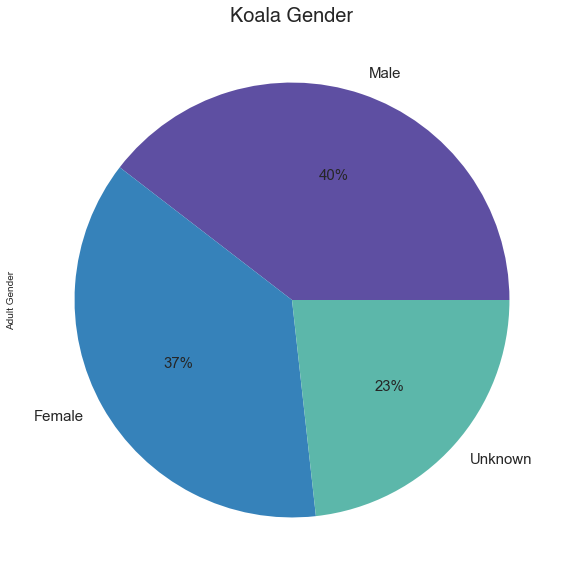

In [26]:
pie()

In [48]:
def size():
    koala_data["Adult Size"].value_counts().plot.bar(color='paleturquoise', rot=0,fontsize=15)
    plt.title("Size of Koalas", fontsize=25)
    plt.xlabel('Size', fontsize=20)
    plt.ylabel('Count', fontsize=20, rotation='horizontal', ha='right')
    return plt.show()


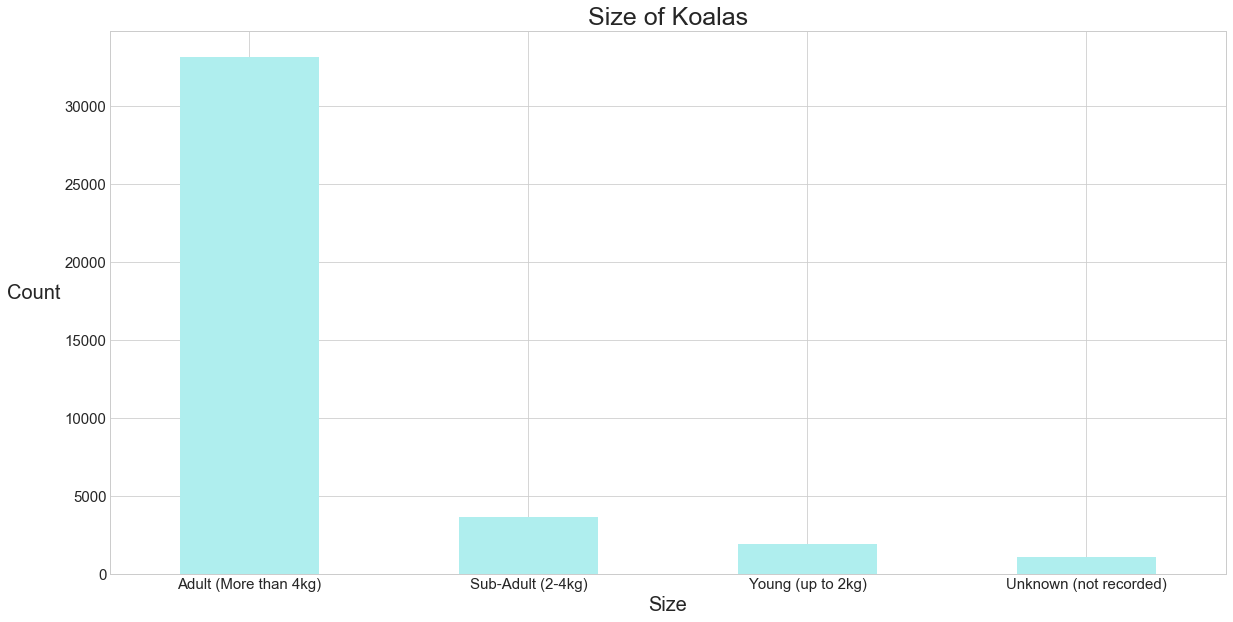

In [49]:
size()

In [50]:
def loc():

    print(koala_data["Adult Situation"].value_counts())
    koala_data["Adult Situation"].value_counts().plot(kind="bar", fontsize=15, rot=0, color='paleturquoise')
    plt.title("Location of Koala", fontsize=25, family= h)
    plt.xlabel('Location', fontsize=20, family= h)
    plt.ylabel('Count', rotation='horizontal', ha='right', fontsize=20, family= h)

    return plt.show()




In tree         16669
On ground       11564
In captivity     3574
Other            2094
Name: Adult Situation, dtype: int64


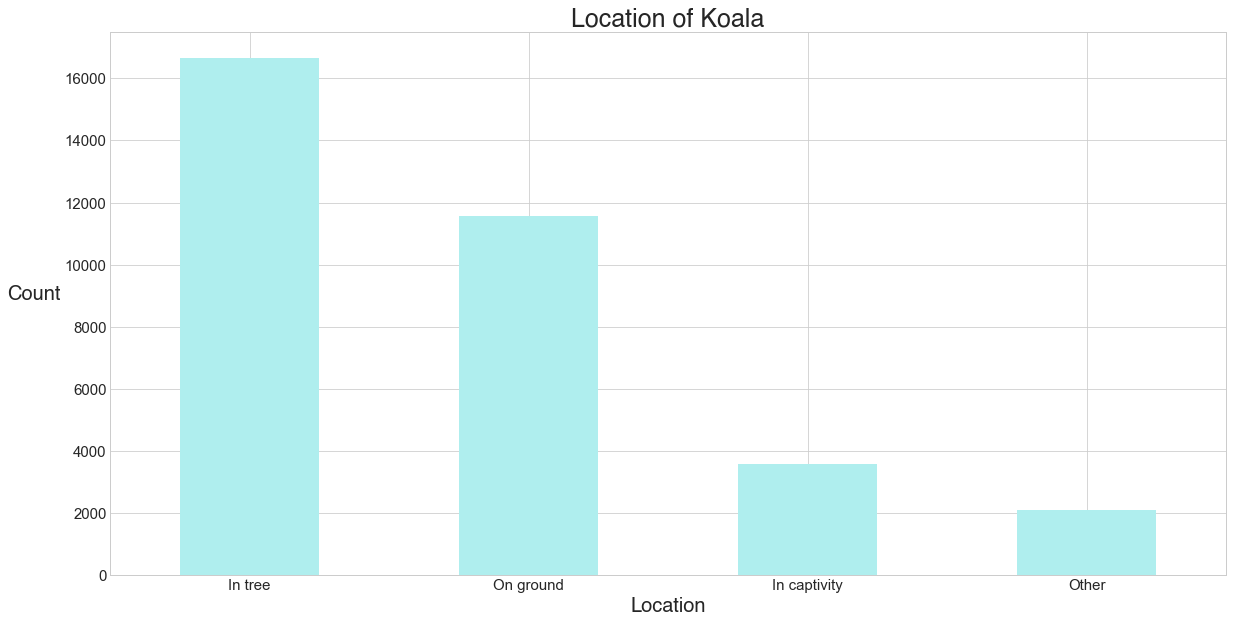

In [51]:
loc()

The names in the "Animal Name" column varied between names and types of sightings i.e."dead", "euthanised". I completed a value count to locate the beginning of the list of names and dropped sightings that weren't given as a name.

In [58]:
def name():
    name = koala_data["Animal Name"].value_counts()
    top25= name[26:54]
    Name = pd.DataFrame({'Koala Name':top25.index, 'Count':top25.values})
    Top25_new= Name.drop([Name.index[5], Name.index[10], Name.index[26]])

    Top25_new.plot.bar(x= 'Koala Name', y= 'Count', color='paleturquoise', figsize=(32,10), rot=0,fontsize=15, legend = None)
    plt.title("Top 25 Koala Names", fontsize=30, family= h)
    plt.xlabel('Names', fontsize=20, family= h)
    plt.ylabel('Count', fontsize=20, rotation='horizontal', ha='right', family= h)

    return plt.show()



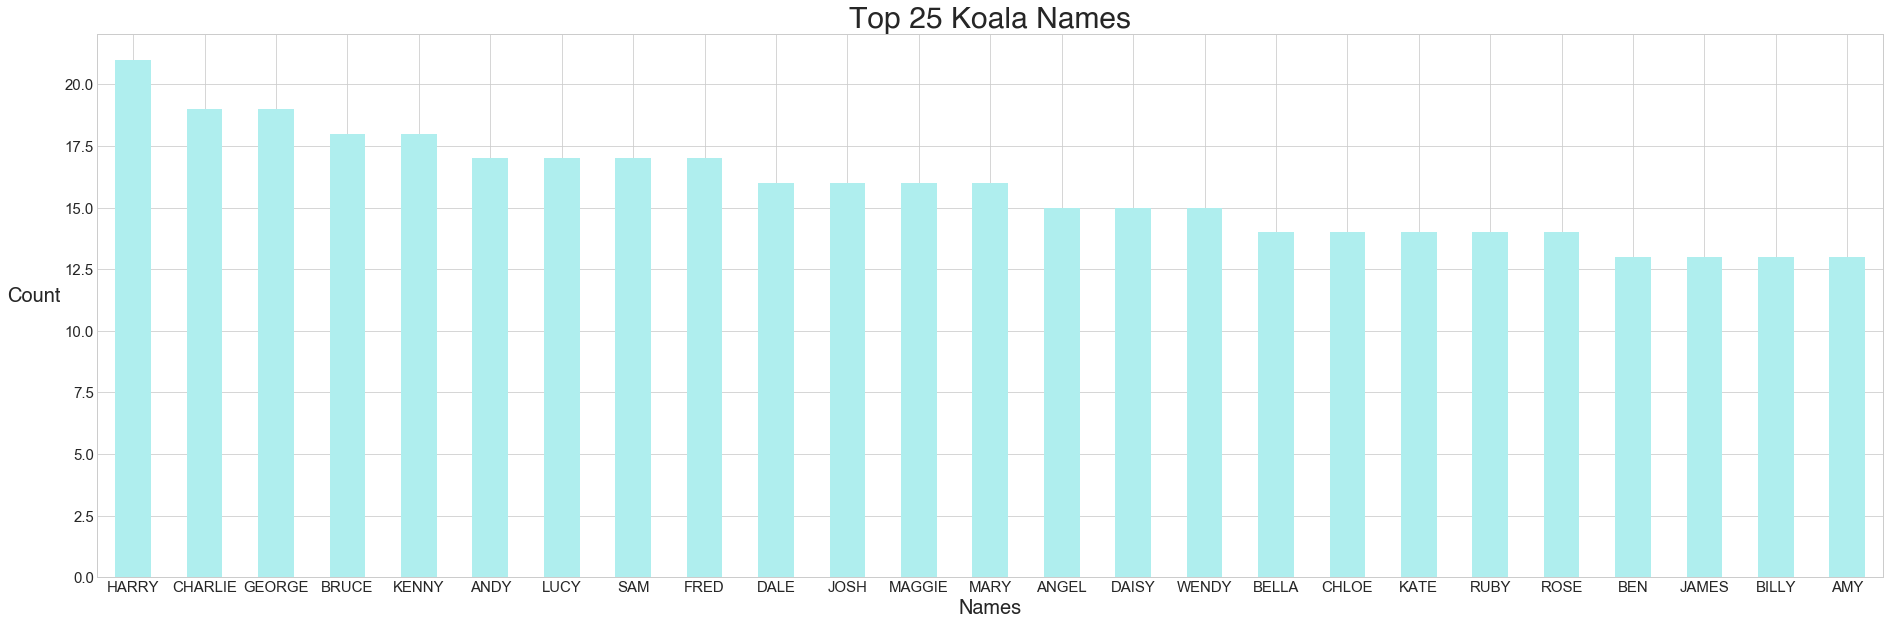

In [59]:
name()

In [52]:
def year():
    year_values=koala_data.groupby(['Year'])['Year'].count().plot(kind='line', linewidth=4, markersize=25, style='.-', fontsize=15, markevery=1, color = 'turquoise', rot=0)
    plt.title("Amount of Reports Made Each Year", fontsize=25, family= h)
    plt.xlabel('Year', fontsize=20, family= h)
    plt.ylabel('Number of Calls', fontsize=20, family= h, rotation='horizontal',ha='right')
    plt.style.use('seaborn-whitegrid')
    plt.show()
    # axis = koala_data.loc[range(1996,2017)]

    return plt.show()

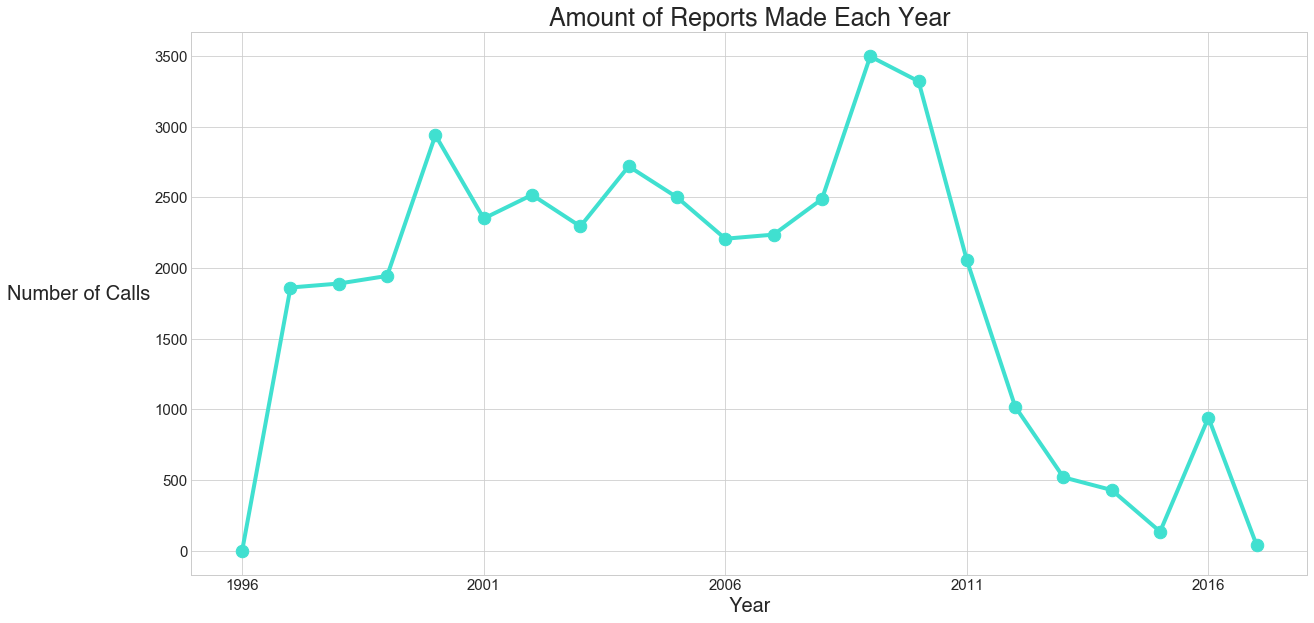

In [53]:
year()

## Why were there so many reports recorded in 2009?

During 2009, south-east Queensland and north-eastern New South Wales were subjected to severe floods that have been described as the region's worst flooding in 30 years. The flooding isolated tens of thousands of people and animals and led to many rescues including koalas! The map provided in the next slide shows how majority of the reports are made around the Brisbane area (south-east QLD).

The next code depicts how I had to trim my QLD map so it was easier to see the location of the reports. I did this by creating a polygon around the map. 

In [29]:
# Create a custom polygon
polygon = Polygon([(148, -29), (148, -20), (154, -20), (154, -29), (148, -29)])
poly_gdf = gp.GeoDataFrame([1], geometry=[polygon], crs=QLD.crs)

QLD_clipped = gp.clip(QLD, polygon)

# # Plot the clipped data
# # The plot below shows the results of the clip function applied to the world
# fig, ax = plt.subplots(figsize=(12, 8))
# QLD_clipped.plot(ax=ax)
# # QLD.boundary.plot(ax=ax) (shows the rest of QLD)
# # poly_gdf.boundary.plot(ax=ax, color="red")
# ax.set_title("QLD Clipped", fontsize=20)
# ax.set_axis_off()



In [30]:
gdf = gp.GeoDataFrame(koala_data, geometry=gp.points_from_xy(koala_data.LONGITUDE, koala_data.LATITUDE))
poly_gdf = gp.GeoDataFrame([1], geometry=[polygon], crs=gdf.crs)
gdf_clipped = gp.clip(gdf, polygon)

def location():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    QLD_clipped.plot(ax=ax, color = 'lightgrey',edgecolor='white')
    gdf_clipped.plot(ax=ax, color= 'indigo', marker=".", markersize=25)
    ax.set_title("Locations of Koala Reports in Queensland", fontsize=20)
    plt.xlabel('Latitude', fontsize=15)
    plt.ylabel('Longitude', rotation='horizontal',ha='right', fontsize=15)
    
    return plt.show()

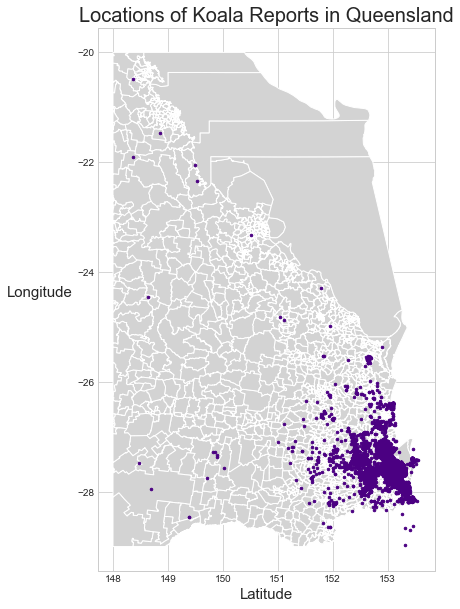

In [31]:
location()

## Suburb and Month Exploration

In [60]:
def burbs():

    # print(koala_data['Koala Suburb'].value_counts(ascending=True).loc[lambda x : x>500])
    c = plt.cm.Spectral_r(np.linspace(0, 2, 23))

    koala_data["Koala Suburb"].value_counts(ascending=False).loc[lambda x : x>500].plot(kind="bar", fontsize=15, color=c)
    plt.title("Suburbs with the Highest Koala Reports", fontsize=25, family= h)
    plt.xlabel('Suburbs', fontsize=20, family= h)
    plt.ylabel('Reports', fontsize=20, rotation='horizontal', ha='right', family= h)

    return plt.show()


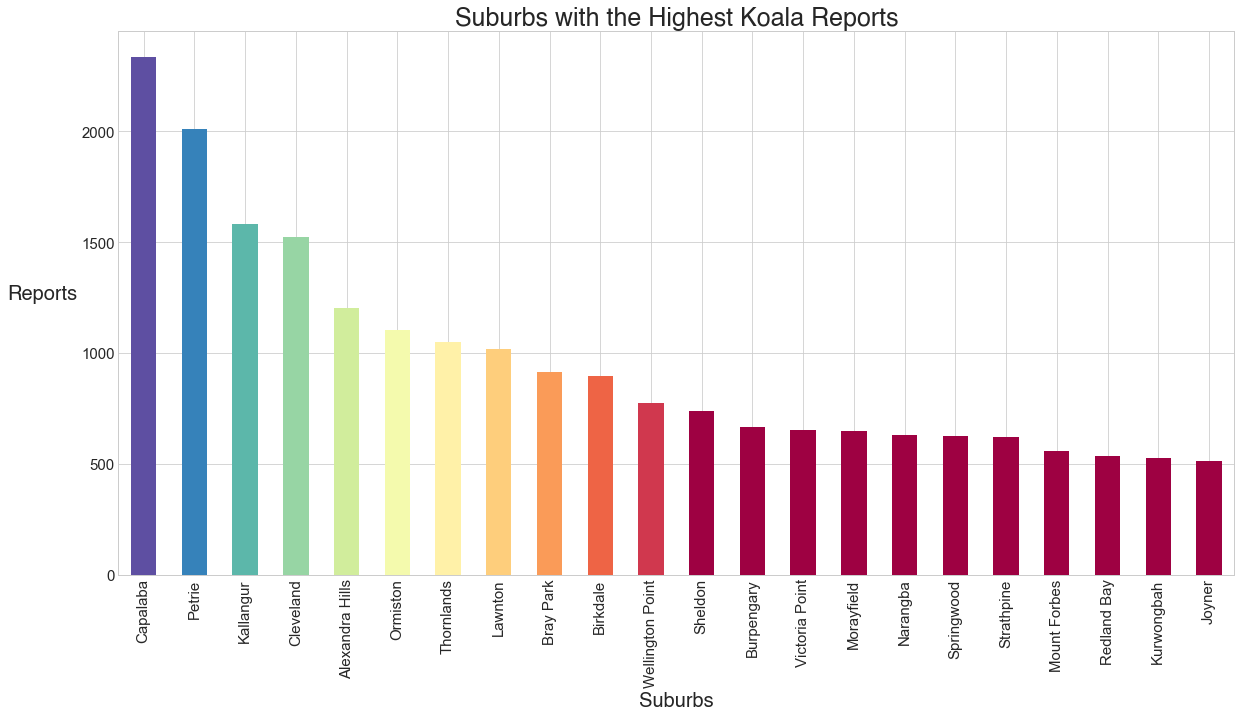

In [61]:
burbs()

Since the koala dataset didn't have the locations of each suburb, I added the report figure to the top 25 suburbs in the QLD map file so I could graph and colour these suburbs more easily.

In [34]:
suburbs= QLD.loc[QLD['QLD_LOCA_2'].isin(['CAPALABA','PETRIE', 'JOYNER', 'KURWONGBAH', 'REDLAND BAY', 'MOUNT FORBES', 'STRATHPINE', 'SPRINGWOOD', 'NARANGBA', 'MORAYFIELD', 'VICTORIA POINT', 'BURPENGARY', 'SHELDON', 'WELLINGTON POINT', 'BIRKDALE', 'BRAY PARK', 'LAWNTON', 'THORNLANDS', 'ORMISTON', 'ALEXANDRA HILLS', 'CLEVELAND', 'KALLANGUR'])]
reports = [1018, 2012, 1584, 667, 916, 514, 1205, 620, 625, 629, 774, 2334, 1522, 1052, 534, 655, 897, 1106, 527, 739, 648, 559]
suburbs.insert(5, "Num_Reports", reports, True)
suburbs = suburbs.sort_values(by ='Num_Reports', ascending= False)
suburbs

,LC_PLY_PID,DT_CREATE,LOC_PID,QLD_LOCALI,QLD_LOCA_2,Num_Reports,geometry
2237,70000,2019-12-05,QLD530,2017-11-09,CAPALABA,2334,"POLYGON ((153.21498 -27.56850, 153.21321 -27.5..."
847,70284,2019-12-05,QLD2361,2018-02-05,PETRIE,2012,"POLYGON ((152.99122 -27.27840, 152.99044 -27.2..."
848,70255,2019-12-05,QLD1506,2018-05-09,KALLANGUR,1584,"POLYGON ((152.99785 -27.27075, 152.99632 -27.2..."
2238,70015,2019-12-05,QLD632,2018-02-05,CLEVELAND,1522,"POLYGON ((153.28494 -27.54972, 153.27912 -27.5..."
1118,66232,2017-12-12,QLD31,2018-02-05,ALEXANDRA HILLS,1205,"POLYGON ((153.23597 -27.56564, 153.23576 -27.5..."
2385,65778,2017-09-12,QLD2289,2017-11-09,ORMISTON,1106,"POLYGON ((153.26057 -27.52434, 153.26028 -27.5..."
2239,70363,2019-12-05,QLD2890,2017-11-09,THORNLANDS,1052,"POLYGON ((153.22875 -27.58999, 153.22875 -27.5..."
28,67865,2018-09-13,QLD1682,2017-11-09,LAWNTON,1018,"POLYGON ((152.98550 -27.29748, 152.98548 -27.2..."
1002,60029,2016-06-29,QLD368,2016-08-10,BRAY PARK,916,"POLYGON ((152.96487 -27.30461, 152.96461 -27.3..."
2269,65271,2017-09-12,QLD266,2017-11-09,BIRKDALE,897,"POLYGON ((153.22777 -27.51541, 153.22771 -27.5..."


In [62]:
def most():
    fig, ax = plt.subplots()
    ax.set_aspect('equal')

    polygon = Polygon([(152.5, -27.9), (152.5, -27), (154, -27), (154, -27.9), (152.5, -27.9)])
    poly_gdf = gp.GeoDataFrame([1], geometry=[polygon], crs=QLD.crs)

    QLD_clipped = gp.clip(QLD, polygon)
    QLD_clipped.plot(ax=ax, color = 'lightgrey',edgecolor='white')
    suburbs.plot(ax=ax, column='Num_Reports', cmap='Spectral', legend=True)
    ax.set_title("Suburbs with the Most Reports", fontsize=20, family= h)
    plt.xlabel('Latitude', fontsize=15, family= h)
    plt.ylabel('Longitude', fontsize=15,rotation='horizontal',ha='right', family= h)

    return plt.show()

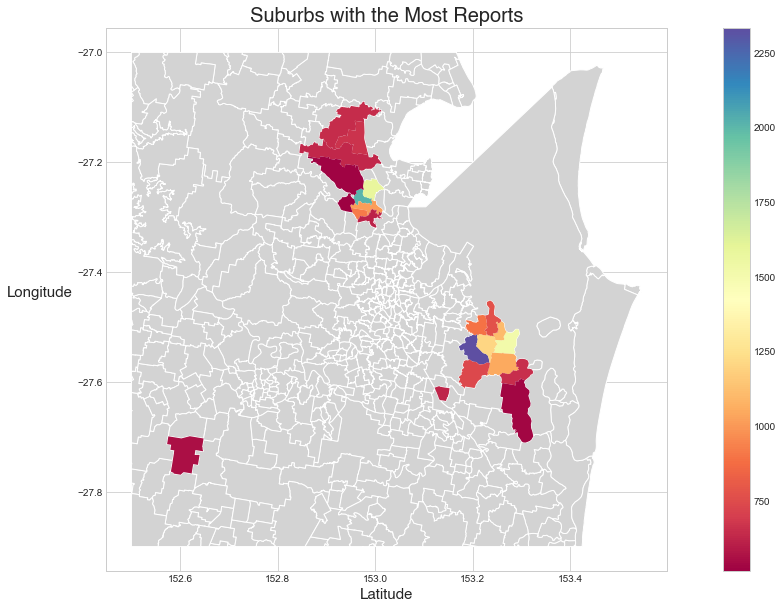

In [63]:
most()

After splitting the dates, I needed to reindex the month values and replace them with the names of the month. 

In [64]:
monthcounts = koala_data["Month"].value_counts().reset_index().rename(columns = {'Month':'Count','index':'Month'})
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
mapping = {month: i for i, month in enumerate(months)}
key = monthcounts['Month'].map(mapping)
monthcounts = monthcounts.iloc[key.argsort()]
monthcounts.index = [0,1,2,3,4,5,6,7,8,9,10,11] 



In [65]:
monthcounts

,Month,Count
0,Jan,2712
1,Feb,2199
2,Mar,2097
3,Apr,2093
4,May,2456
5,Jun,2631
6,Jul,3690
7,Aug,4961
8,Sep,5306
9,Oct,5125


I struggled to create this graph, mainly due to me overthinking what code needs to occur. Using the pivot function was the easiest and most cohesive way to obtain the graph. 

In [66]:
def stack():
    df= koala_data[['Year','Month']].dropna()

    df['Counter'] =1 
    Count = df.groupby(['Year','Month']).sum()#sum function

    Count.reset_index(level=['Month','Year'])
    data= Count.reset_index(level=['Month','Year'])

    pivot_df = data.pivot(index='Month', columns='Year', values='Counter')
    new_index = ['Jan','Feb', 'Mar','Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    month_yr = pivot_df.reindex(new_index)

    colors = plt.cm.Spectral(np.linspace(0, 1, 25))

    #Note: .loc[:,[1996','1997', '1998']] is used here to rearrange the layer ordering
    month_yr.loc[:,['1996','1997', '1998','1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017']].plot.bar(stacked=True,color=colors, figsize=(12,11), rot=0,fontsize=15)
    plt.title("Amount of Reports Made Each Month", fontsize=25, family= h)
    plt.xlabel('Months', fontsize=20, family= h)
    plt.ylabel('Reports', fontsize=20, rotation='horizontal', ha='right', family= h)
    plt.legend(loc='upper right', bbox_to_anchor=(1.12, 1.005),title="Year",fontsize='medium', fancybox=True)
    
    return plt.show()


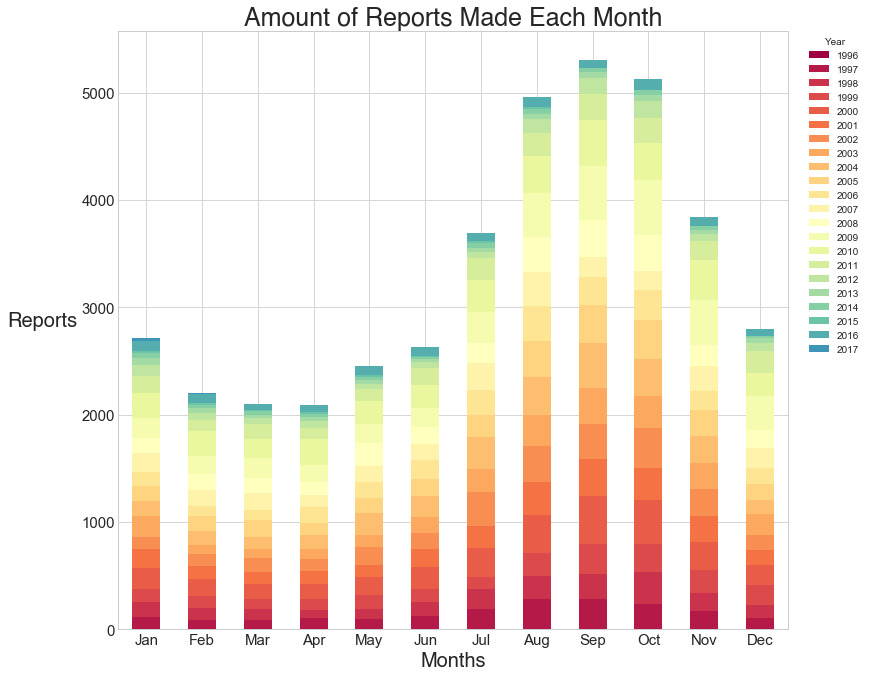

In [67]:
stack()

In [70]:
def purp(): 
    new_df = koala_data[['Vehicle Hit','Cystitis','Dead', 'Conjunctivitis','Caused By Dog','Orphaned', 'Fall']]
    true_data = new_df.apply(pd.Series.value_counts)
    true_data = true_data.drop(true_data.index[0])
    true_data_T= true_data.T
    true_data_T.index.name = 'Report Type'
    true_data_T = true_data_T.rename(columns={True:'Count'})

    true_data_T.plot.bar(color='paleturquoise', rot=0,fontsize=15, legend = None)
    plt.title("Purpose of each Report", fontsize=25, family= h)
    plt.xlabel('Cause', fontsize=20, family= h)
    plt.ylabel('Count', fontsize=20, rotation='horizontal', ha='right', family= h)
    return plt.show()

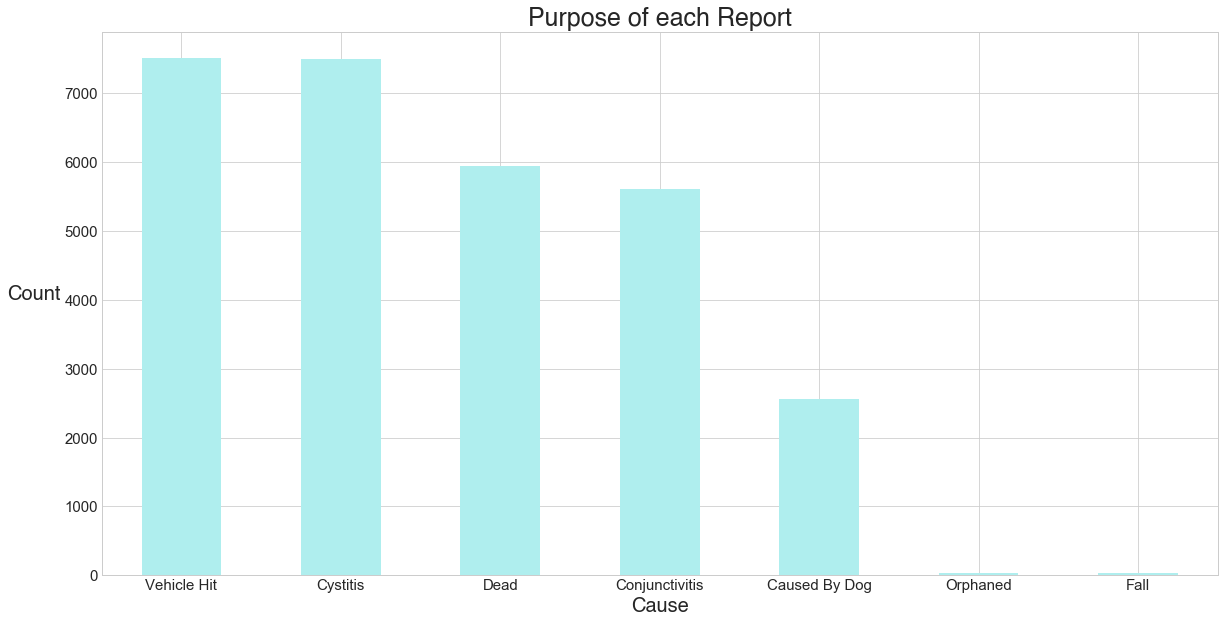

In [71]:
purp()

There was definitely a faster and more effective way to get the top 5 suburbs for each case shown above. However, this way I was able to understand more and could get what table I wanted from the results.

In [40]:
new_df2 = koala_data[['Koala Suburb','Vehicle Hit','Cystitis','Dead', 'Conjunctivitis','Caused By Dog','Orphaned', 'Fall']]
most = new_df2.dropna()


Vehicle = most[['Koala Suburb', 'Vehicle Hit']]
Vehicle = Vehicle[(Vehicle["Vehicle Hit"] == True)]
Vehicle = Vehicle.groupby(['Vehicle Hit','Koala Suburb']).size().reset_index().groupby('Koala Suburb')[[0]].max()
Vehicle = Vehicle.rename(columns={0:'Vehicle'})
Vehicle = Vehicle.sort_values(by ='Vehicle' , ascending=False)
Vehicle= Vehicle[0:5]



In [41]:
Cystitis = most[['Koala Suburb', 'Cystitis']]
Cystitis = Cystitis[(Cystitis["Cystitis"] == True)]
Cystitis = Cystitis.groupby(['Cystitis','Koala Suburb']).size().reset_index().groupby('Koala Suburb')[[0]].max()
Cystitis = Cystitis.rename(columns={0:'Cystitis'})
Cystitis = Cystitis.sort_values(by ='Cystitis' , ascending=False)
Cystitis = Cystitis[0:5]

In [42]:
Dead = most[['Koala Suburb', 'Dead']]
Dead = Dead[(Dead["Dead"] == True)]
Dead = Dead.groupby(['Dead','Koala Suburb']).size().reset_index().groupby('Koala Suburb')[[0]].max()
Dead = Dead.rename(columns={0:'Dead'})
Dead = Dead.sort_values(by ='Dead' , ascending=False)
Dead = Dead[0:5]


In [43]:
Conjunctivitis = most[['Koala Suburb', 'Conjunctivitis']]
Conjunctivitis = Conjunctivitis[(Conjunctivitis["Conjunctivitis"] == True)]
Conjunctivitis = Conjunctivitis.groupby(['Conjunctivitis','Koala Suburb']).size().reset_index().groupby('Koala Suburb')[[0]].max()
Conjunctivitis = Conjunctivitis.rename(columns={0:'Conjuctivitis'})
Conjunctivitis = Conjunctivitis.sort_values(by ='Conjuctivitis' , ascending=False)
Conjunctivitis = Conjunctivitis[0:5]


In [44]:
Dog = most[['Koala Suburb', 'Caused By Dog']]
Dog = Dog[(Dog["Caused By Dog"] == True)]
Dog = Dog.groupby(['Caused By Dog','Koala Suburb']).size().reset_index().groupby('Koala Suburb')[[0]].max()
Dog = Dog.rename(columns={0:'Dog'})
Dog = Dog.sort_values(by ='Dog' , ascending=False)
Dog = Dog[0:5]


In [45]:
Orphaned = most[['Koala Suburb', 'Orphaned']]
Orphaned = Orphaned[(Orphaned["Orphaned"] == True)]
Orphaned = Orphaned.groupby(['Orphaned','Koala Suburb']).size().reset_index().groupby('Koala Suburb')[[0]].max()
Orphaned = Orphaned.rename(columns={0:'Orphaned'})
Orphaned = Orphaned.sort_values(by ='Orphaned' , ascending=False)
Orphaned = Orphaned[0:5]

In [46]:
Fall = most[['Koala Suburb', 'Fall']]
Fall = Fall[(Fall["Fall"] == True)]
Fall = Fall.groupby(['Fall','Koala Suburb']).size().reset_index().groupby('Koala Suburb')[[0]].max()
Fall = Fall.rename(columns={0:'Fall'})
Fall = Fall.sort_values(by ='Fall' , ascending=False)
Fall = Fall[0:5]


In [77]:
def cause(): 
    Cause = [Vehicle, Cystitis, Dead, Conjunctivitis , Dog, Orphaned, Fall]
    Cause = pd.concat(Cause, axis=1)
    r = plt.cm.Spectral_r(np.linspace(0, 5, 30))
    Cause.plot.bar(fontsize=15, legend = True, color=r, figsize=(20,10))
    plt.title("Surburbs with Highest Count of Different Reports", fontsize=25, family= h)
    plt.xlabel('Suburbs', fontsize=20, family= h)
    plt.ylabel('Count', fontsize=20, rotation='horizontal', ha='right', family= h)
    plt.legend(loc='upper right',title="Cause",fontsize='large', fancybox=True)



In [78]:
Cause

,Vehicle,Cystitis,Dead,Conjuctivitis,Dog,Orphaned,Fall
Capalaba,460.0,648.0,407.0,474.0,138.0,NaN,NaN
Thornlands,326.0,NaN,236.0,247.0,NaN,NaN,NaN
Petrie,290.0,NaN,209.0,NaN,155.0,2.0,2.0
Kallangur,275.0,NaN,171.0,NaN,125.0,2.0,NaN
Cleveland,253.0,331.0,NaN,276.0,NaN,NaN,NaN
Ormiston,NaN,303.0,NaN,244.0,NaN,NaN,NaN
Alexandra Hills,NaN,286.0,187.0,236.0,87.0,NaN,NaN
Sheldon,NaN,278.0,NaN,NaN,NaN,NaN,NaN
Lawnton,NaN,NaN,NaN,NaN,92.0,NaN,NaN
Kurwongbah,NaN,NaN,NaN,NaN,NaN,3.0,NaN


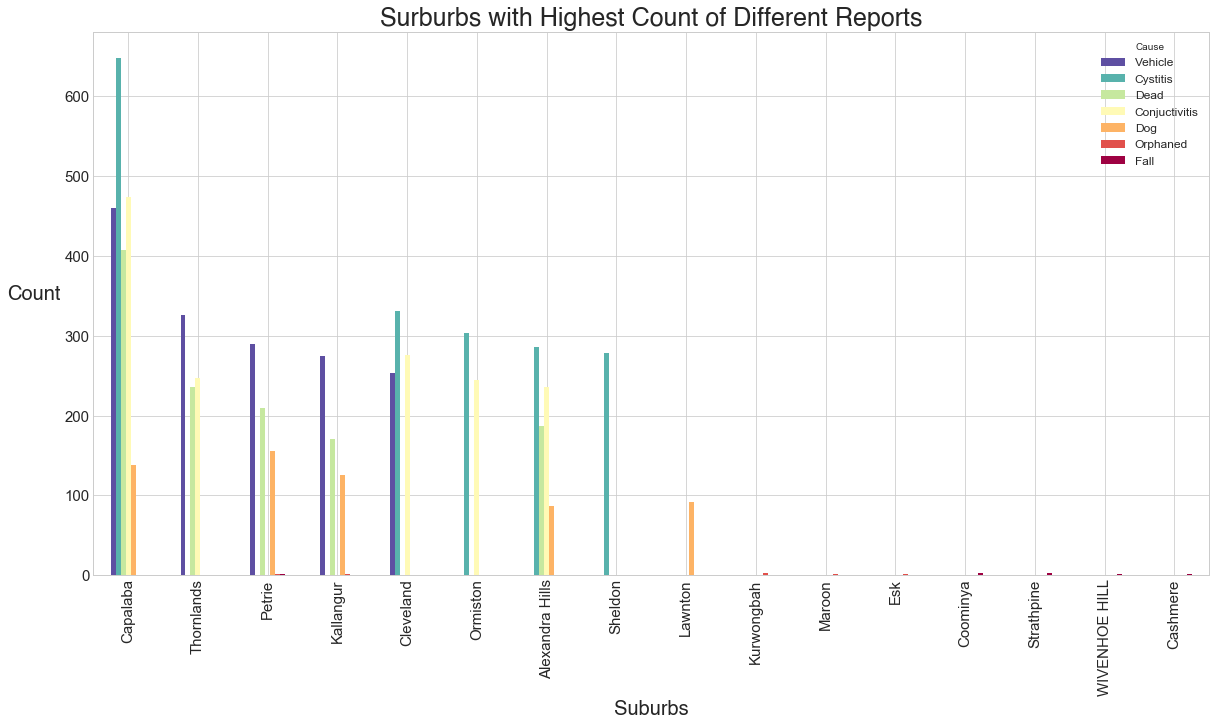

In [79]:
cause()

# Conclusion

 - If you decide to become a koala maybe don't head to Capalaba since it has the highest rates of koala reports including vehicle hits, cases of Cystitis and Conjuctivitis and koala deaths.
 - If you ever drive through the Queensland suburbs: Capalaba, Thornlands, Petrie, Kallangur or Cleveland, SLOW DOWN and look out for koalas on the road.
 - If you ever have the opportunity to name a koala, have some orginality and name it something other than Harry, Charlie or George. 

**Possible Further Exploration**

- I would gather more data to compare the trends to 2018 and 2019 and see whether the number of reports was increasing or decreasing.
- It would be interesting to see which year and month had the most reports over the most amount of suburbs.
- I would explore in more depth why there was a drastic decreae in the number of reports in the past few years


